## Getting Data

In [123]:
from fastbook import *
import os
from fastai.vision.widgets import *

In [124]:
folder_name='Confusing_Animals'
if not os.path.exists(folder_name):
    os.mkdir(folder_name)

In [125]:
crocs='Gharial','Crocodile','Alligator'
path=Path('C:/Users/Python/Fast-AI/Confusing_Animals/')
for o in crocs:
    dest=Path(path/o)
    dest.mkdir(exist_ok=True)
    results=search_images_ddg(f'{o} photo')
    download_images(dest,urls=results[:200])
    resize_images(dest,max_size=400,dest=dest)

In [126]:
fns=get_image_files(path)
fns

(#1063) [Path('C:/Users/vardh/Python/Fast-AI/Confusing_Animals/Alligator/00743fe2-8ffe-4cfe-8222-143a113d635a.jpg'),Path('C:/Users/vardh/Python/Fast-AI/Confusing_Animals/Alligator/01f3553e-56a7-49a7-8c03-d2edbc5dac0e.jpg'),Path('C:/Users/vardh/Python/Fast-AI/Confusing_Animals/Alligator/02da4b2c-62ac-4514-a944-bf2120a3993a.jpg'),Path('C:/Users/vardh/Python/Fast-AI/Confusing_Animals/Alligator/02de2b2a-4c76-4922-be7d-05285ca005ed.jpg'),Path('C:/Users/vardh/Python/Fast-AI/Confusing_Animals/Alligator/030920d1-88ed-465d-80dd-5a9569c80325.JPG'),Path('C:/Users/vardh/Python/Fast-AI/Confusing_Animals/Alligator/0399b2f9-3de5-4c50-a636-5116aa721a80.jpg'),Path('C:/Users/vardh/Python/Fast-AI/Confusing_Animals/Alligator/047ac58b-8d03-4d1f-a972-19e5da31f323.jpg'),Path('C:/Users/vardh/Python/Fast-AI/Confusing_Animals/Alligator/0799b3a4-9024-4495-9a71-803fcc2dea97.jpg'),Path('C:/Users/vardh/Python/Fast-AI/Confusing_Animals/Alligator/07c0cfc5-de91-41f8-bd72-be5fbe86b0c5.jpg'),Path('C:/Users/vardh/Python/

In [127]:
failed=verify_images(fns)
failed.map(Path.unlink)

(#15) [None,None,None,None,None,None,None,None,None,None...]

## Model Building & Data Cleaning

In [128]:
crocs_block=DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2,seed=42),
    get_y=parent_label,
    item_tfms=Resize(224))

In [129]:
dls=crocs_block.dataloaders(path)

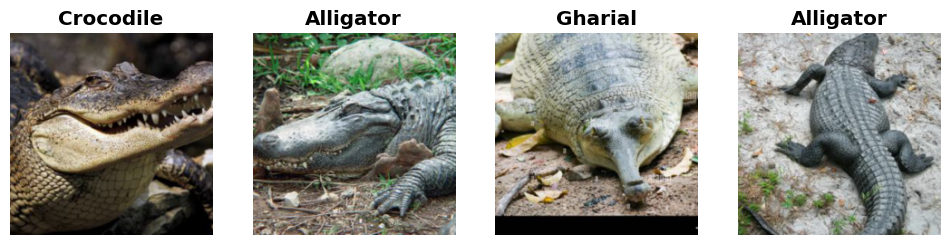

In [130]:
dls.valid.show_batch(max_n=4,nrows=1)

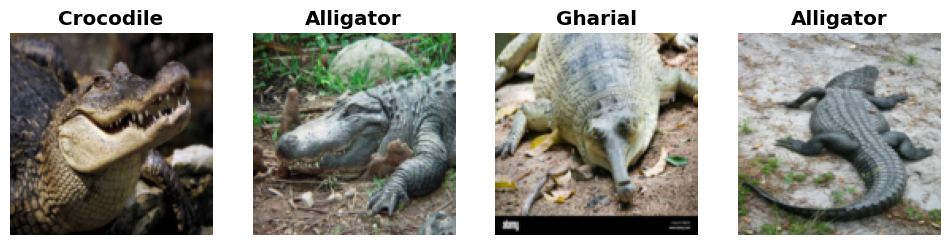

In [131]:
crocs_block=crocs_block.new(item_tfms=Resize(128,ResizeMethod.Squish))
dls=crocs_block.dataloaders(path)
dls.valid.show_batch(max_n=4,nrows=1)

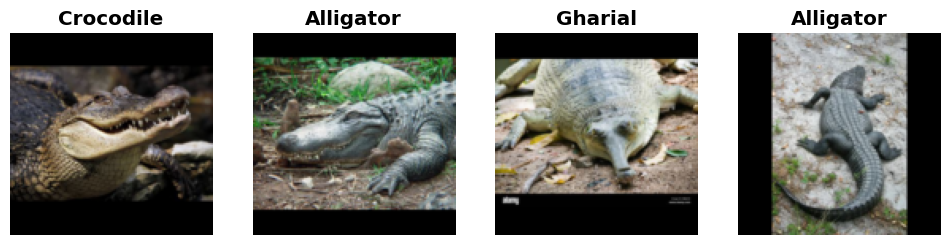

In [132]:
crocs_block=crocs_block.new(item_tfms=Resize(128,ResizeMethod.Pad,pad_mode='zeros'))
dls=crocs_block.dataloaders(path)
dls.valid.show_batch(max_n=4,nrows=1)

## Data Augmentation

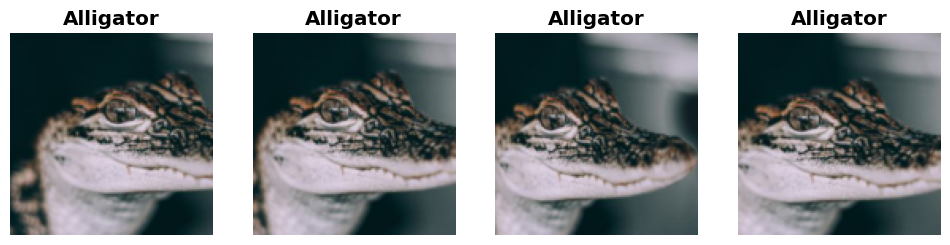

In [133]:
crocs_block=crocs_block.new(item_tfms=RandomResizedCrop(128,min_scale=0.5))
dls=crocs_block.dataloaders(path)
dls.train.show_batch(max_n=4,nrows=1, unique=True)

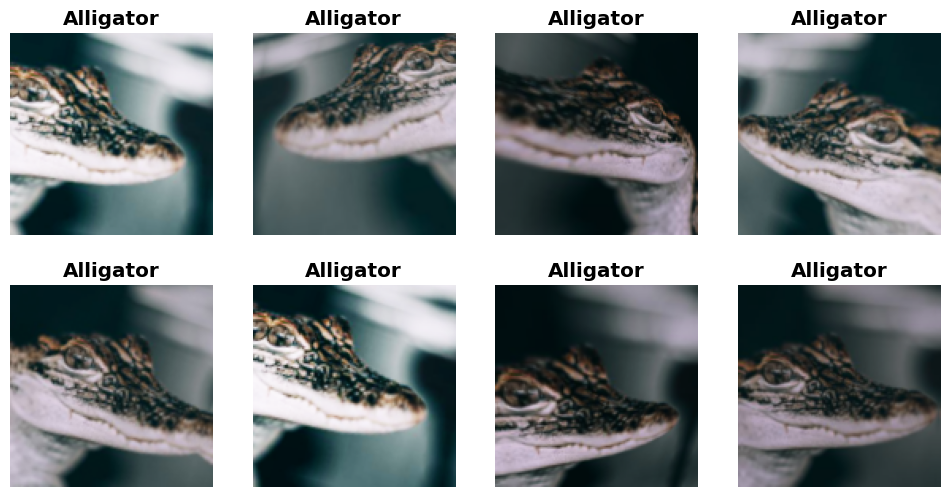

In [134]:
crocs_block=crocs_block.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls=crocs_block.dataloaders(path)
dls.train.show_batch(max_n=8,nrows=2, unique=True)

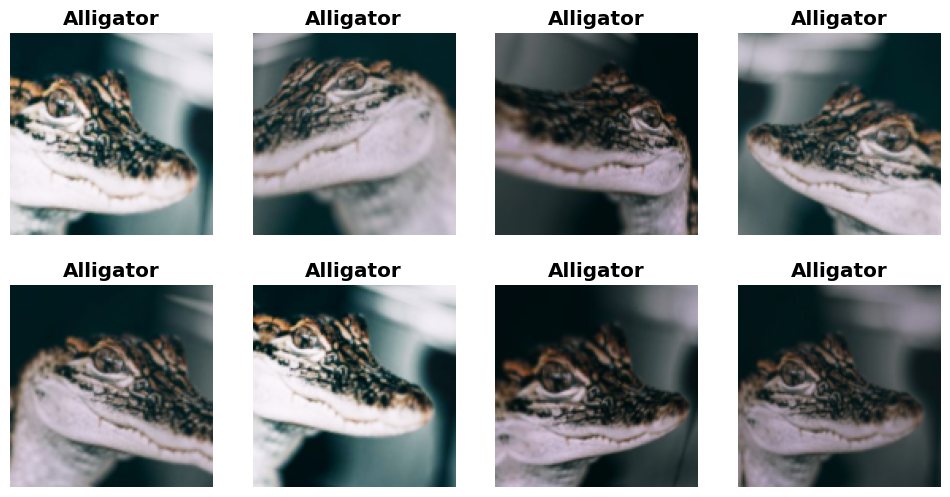

In [135]:
crocs_block=crocs_block.new(item_tfms=RandomResizedCrop(128,min_scale=0.5), batch_tfms=aug_transforms(mult=2))
dls=crocs_block.dataloaders(path)
dls.train.show_batch(max_n=8,nrows=2, unique=True)

In [136]:
crocs_block=crocs_block.new(
    item_tfms=RandomResizedCrop(224,min_scale=0.5),
    batch_tfms=aug_transforms())
dls=crocs_block.dataloaders(path)

In [137]:
learn=vision_learner(dls,resnet18,metrics=error_rate)
learn.fine_tune(5)

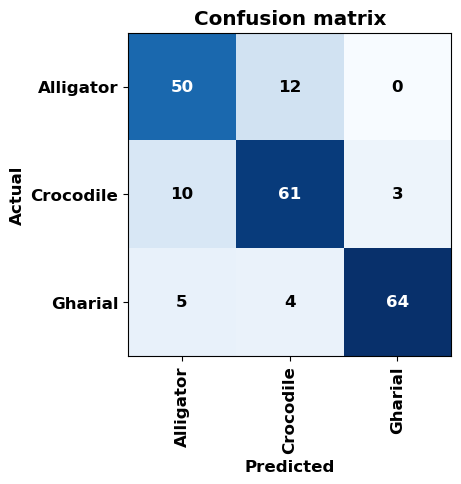

In [139]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

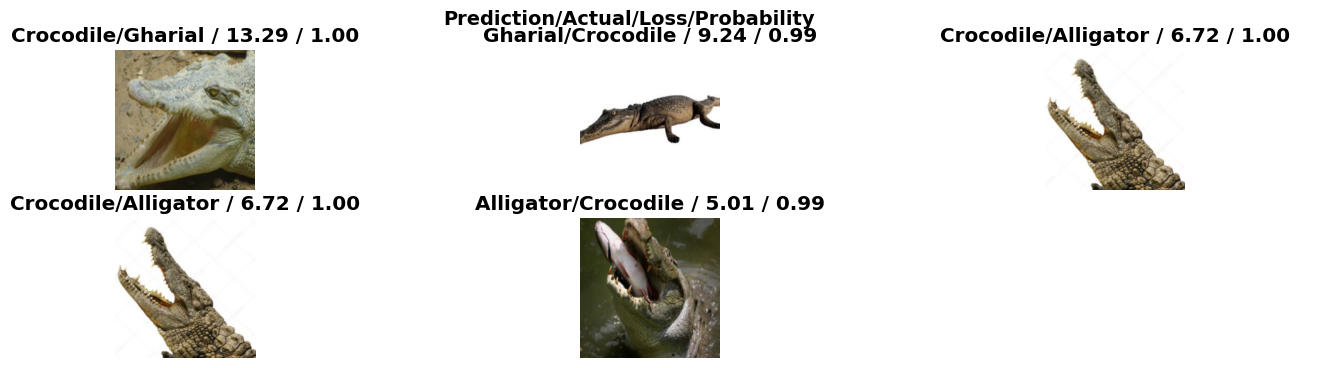

In [141]:
interp.plot_top_losses(5, figsize=(17,4))

In [142]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [143]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,imag in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/imag)

## Retrain Model and Check Performance

In [144]:
crocs_block=DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2,seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224,min_scale=0.5),
    batch_tfms=aug_transforms(flip_vert=True, max_rotate=30.0, max_zoom=1.2, max_lighting=0.4, max_warp=0.4, p_lighting=0.75))

dls=crocs_block.dataloaders(path)

In [145]:
learn=vision_learner(dls,resnet18,metrics=error_rate,wd=0.1)
learn.fine_tune(5)

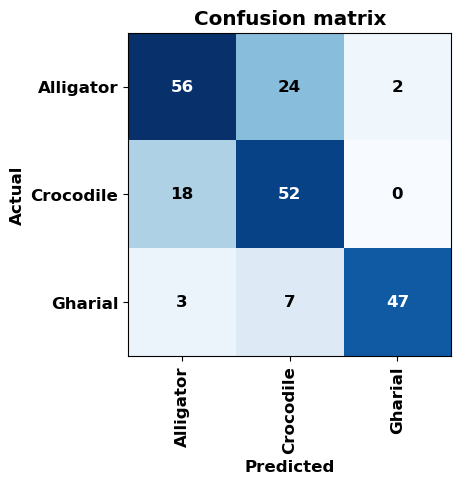

In [147]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

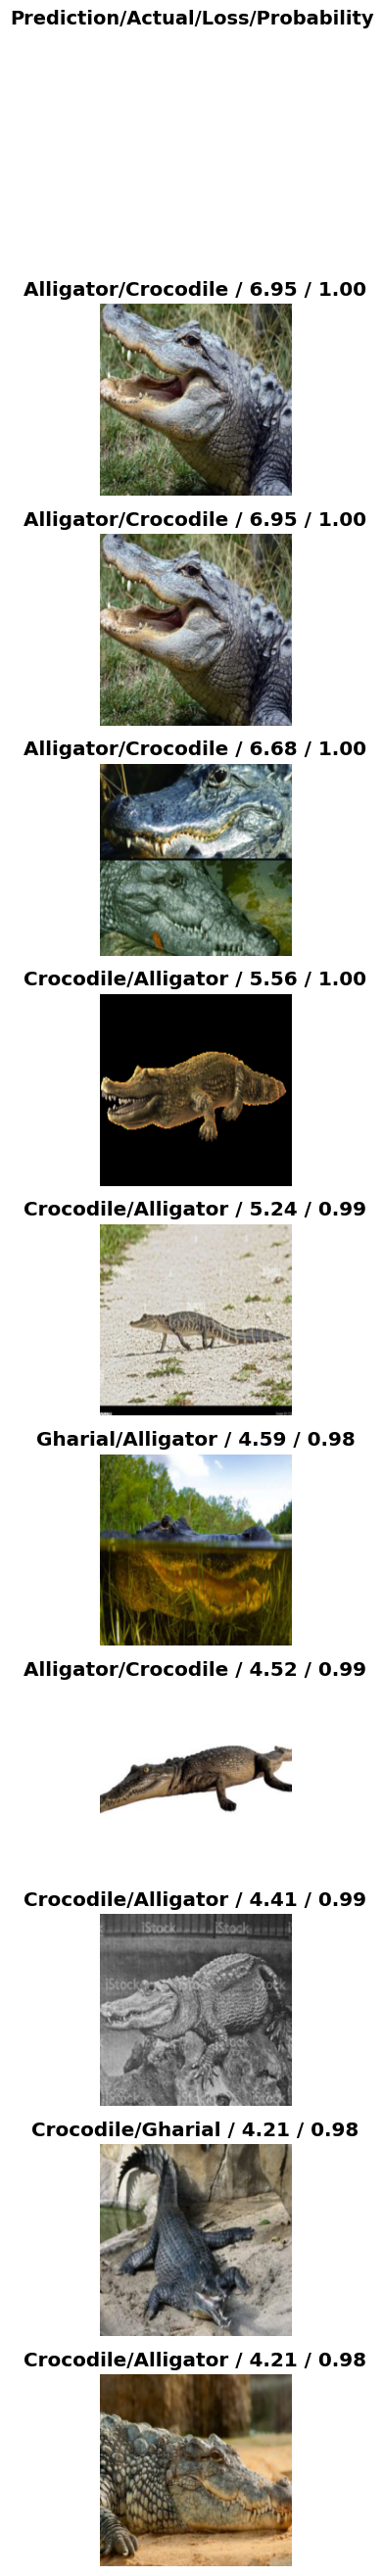

In [148]:
interp.plot_top_losses(10, nrows=10)

## Saving Model & Recall

In [149]:
learn.export()

In [150]:
path=Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [151]:
learn_inf=load_learner(path/'export.pkl')

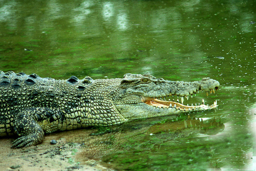

In [159]:
urls=search_images_ddg('crocodile',max_images=1)
dest=Path('crocodile.jpg')
if not dest.exists(): download_url(urls[0],dest,show_progress=False)
im=Image.open(dest)
im.to_thumb(256,256)

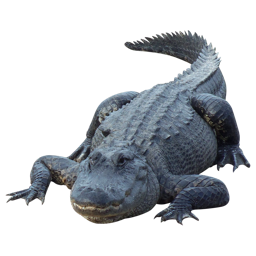

In [173]:
urls=search_images_ddg('alligator clear',max_images=1)
dest=Path('alligator.jpg')
if not dest.exists(): download_url(urls[0],dest,show_progress=False)
im=Image.open(dest)
im.to_thumb(256,256)

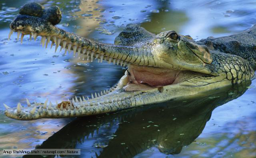

In [162]:
urls=search_images_ddg('Gharial photo',max_images=1)
dest=Path('gharial.jpg')
if not dest.exists(): download_url(urls[0],dest,show_progress=False)
im=Image.open(dest)
im.to_thumb(256,256)

In [165]:
learn_inf.dls.vocab

['Alligator', 'Crocodile', 'Gharial']

In [174]:
learn_inf.predict('alligator.jpg')

('Alligator', tensor(0), tensor([5.3145e-01, 4.6813e-01, 4.2205e-04]))

In [168]:
learn_inf.predict('crocodile.jpg')

('Crocodile', tensor(1), tensor([4.6424e-04, 9.9102e-01, 8.5201e-03]))

## Widgets

In [175]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [176]:
img=PILImage.create(btn_upload.data[-1])

In [177]:
out_pl=widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [178]:
pred,pred_idx,probs=learn_inf.predict(img)

In [179]:
lbl_pred=widgets.Label()
lbl_pred.value=f'Prediction: {pred}; Probability: {probs[pred_idx]: .04f}'
lbl_pred

Label(value='Prediction: Crocodile; Probability:  0.9910')

In [182]:
btn_run=widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [ ]:
def on_click_classify(change):
    img=PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs=learn_inf.predict(img)
    lbl_pred.value=f'Prediction: {pred}; Probability: {probs[pred_idx]: .04f}'

In [ ]:
btn_run.on_click(on_click_classify)

In [ ]:
VBox([widgets.Label('Crocs, Alligators, Gharials!'),
 btn_upload, btn_run, out_pl, lbl_pred])